In [1]:
from mobster_mv import mobster_MV
from BoundedPareto import BoundedPareto
from create_beta_pareto_dataset import pareto_binomial_component, beta_binomial_component, pareto_binomial_component2, beta_binomial_component2 
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics.cluster import normalized_mutual_info_score
%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
N1 = 2000
N2 = 1000
seed = 12
# NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.2, n=100, N=N1, seed = seed)
# NV2, DP2 = beta_binomial_component(p_x=0.8, p_y=0.6, n=150, N=N2, seed=seed)
NV1, DP1 = pareto_binomial_component2(alpha=2, L=0.05, H=0.5, a=0.5, b = 0.5, n=100, N=N1, seed = seed)
NV2, DP2 = beta_binomial_component2(a_x = 0.5, b_x = 0.5, a_y= 0.5, b_y= 0.5, n=150, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([3000, 2])
torch.Size([3000, 2])


(array([ 73., 282., 440., 402., 255., 150., 111.,  96.,  47.,  28.,  18.,
         18.,  21.,  17.,   8.,   7.,   6.,   6.,   4.,   4.,   1.,   2.,
          0.,   1.,   0.,   0.,   0.,   0.,   1.,   2.]),
 array([0.        , 0.02133333, 0.04266667, 0.064     , 0.08533333,
        0.10666666, 0.12799999, 0.14933333, 0.17066666, 0.192     ,
        0.21333332, 0.23466666, 0.25599998, 0.27733332, 0.29866666,
        0.31999999, 0.34133333, 0.36266667, 0.384     , 0.40533331,
        0.42666665, 0.44799998, 0.46933332, 0.49066666, 0.51199996,
        0.5333333 , 0.55466664, 0.57599998, 0.59733331, 0.61866665,
        0.63999999]),
 <BarContainer object of 30 artists>)

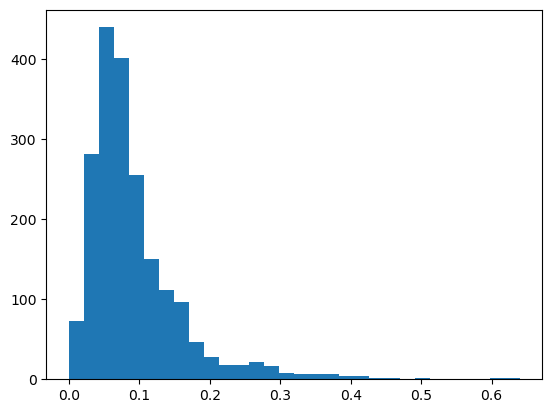

In [34]:
# Plot marginal of Pareto component
plt.hist(NV1[:,0].numpy()/DP1[:,0].numpy(), bins = 30)

In [35]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

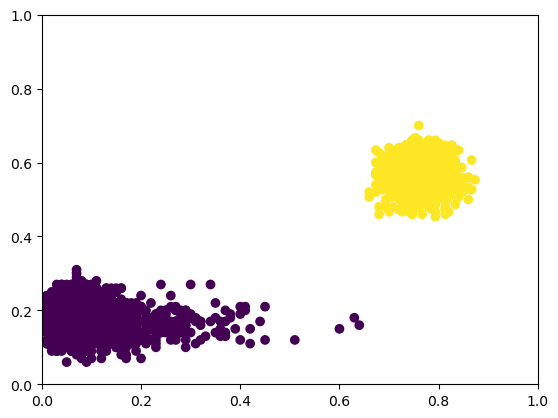

In [36]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [50]:
mb = mobster_MV(NV, DP, K = 2, seed = 10)
# seed = 13 o 10 e std_dev = 0.5 le probs partono da 1 e non si muovono
# seed = 12 o 123 ok

Beta:  tensor([[0.7342, 0.5121],
        [0.0772, 0.1100]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[0.7342, 0.5121],
        [0.0772, 0.1100]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 97306248.0
Beta:  tensor([[0.7344, 0.5124],
        [0.0773, 0.1101]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[0.7344, 0.5124],
        [0.0772, 0.1101]], grad_fn=<ClampBackward1>)
Beta:  tensor([[0.7346, 0.5126],
        [0.0774, 0.1102]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[0.7346, 0.5126],
        [0.0771, 0.1102]], grad_fn=<ClampBackward1>)
Beta:  tensor([[0.7348, 0.5129],
        [0.0774, 0.1103]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[0.7348, 0.5129],
        [0.0770, 0.1103]], grad_fn=<ClampBackward1>)
Beta:  tensor([[0.7350, 0.5131],
        [0.0775, 0.1104]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[0.7350, 0.5131],
        [0.0769, 0.1104]], grad_fn=<ClampBackward1>)
Beta:  tensor([[0.7352, 0.5134],
        [0.0776, 0.1105]], grad_fn=<ClampBackward1>)
Pareto:  tens

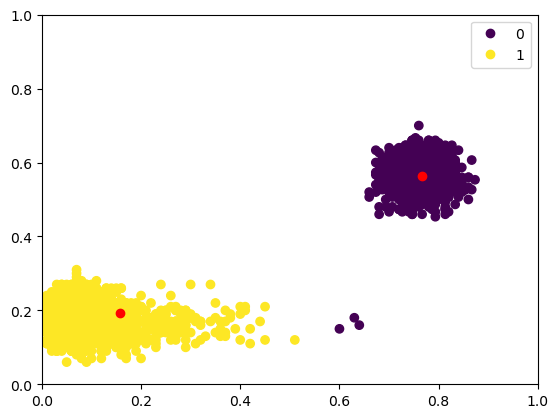

In [51]:
mb.fit(num_iter = 3000, lr = 0.001)

In [53]:
# Results obtained with gaussian noise
mb.params

{'probs_beta': tensor([[0.7662, 0.5644],
         [0.1570, 0.1928]]),
 'probs_pareto': tensor([[0.4068, 0.1524],
         [0.0424, 0.0969]]),
 'weights': tensor([0.3399, 0.6601]),
 'delta': tensor([[[0.0152, 0.9848],
          [0.0654, 0.9346]],
 
         [[0.5804, 0.4196],
          [0.0344, 0.9656]]]),
 'alpha_pareto': tensor([[0.1665, 0.1987],
         [0.2898, 0.5955]]),
 'phi_beta': tensor([[0.7658, 0.5643],
         [0.2000, 0.2000]]),
 'k_beta': tensor([[663.2436, 662.2831],
         [ 60.3979, 388.0048]]),
 'responsib': tensor([[0., 0., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 'cluster_assignments': tensor([1, 1, 1,  ..., 0, 0, 0])}

In [41]:
nmi = normalized_mutual_info_score(labels, mb.params['cluster_assignments']) # normalized_mutual_info_score(labels_true, labels_pred)
print(nmi) # 0 (no mutual information) and 1 (perfect correlation)

0.9887634724387593


In [25]:
mb.params['responsib'].T.shape

torch.Size([3000, 2])

In [26]:
# a = mb.params['responsib'].T
# a = a.numpy()
# print(a)
# seaborn.clustermap(a[(a[:,0] > 0.2)  & (a[:,0] < 0.8)], vmin=0, vmax=1)

### Using 3 components

In [14]:
N1 = 2000
N2 = 1000
N3 = 2000
NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.5, n=100, N=N1, seed = 123)
NV2, DP2 = beta_binomial_component(p_x=0.5, p_y=0.5, n=150, N=N2, seed=123)
NV3, DP3 = beta_binomial_component(p_x=0.3, p_y=0.3, n=150, N=N3, seed=123)
NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP) 

torch.Size([5000, 2])
torch.Size([5000, 2])


In [15]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

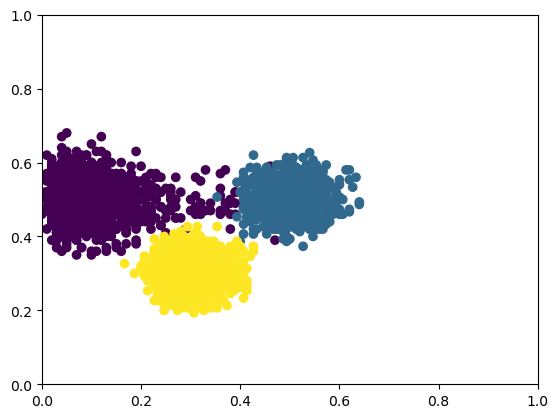

In [16]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [19]:
mb = mobster_MV(NV, DP, K = 3, seed = 12)

Beta:  tensor([[0.0856, 0.4998],
        [0.3014, 0.3020],
        [0.4965, 0.5030]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[0.0856, 0.4998],
        [0.3014, 0.3020],
        [0.4965, 0.5030]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 113123224.0
Beta:  tensor([[0.0856, 0.4996],
        [0.3012, 0.3018],
        [0.4963, 0.5027]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[0.0856, 0.4996],
        [0.3012, 0.3018],
        [0.4963, 0.5027]], grad_fn=<ClampBackward1>)
Beta:  tensor([[0.0855, 0.4997],
        [0.3010, 0.3016],
        [0.4961, 0.5025]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[0.0855, 0.4993],
        [0.3010, 0.3016],
        [0.4960, 0.5025]], grad_fn=<ClampBackward1>)
Beta:  tensor([[0.0854, 0.4999],
        [0.3008, 0.3014],
        [0.4958, 0.5022]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[0.0854, 0.4991],
        [0.3008, 0.3014],
        [0.4958, 0.5022]], grad_fn=<ClampBackward1>)
Beta:  tensor([[0.0853, 0.5000],
        [0.3006, 0.3012],
     

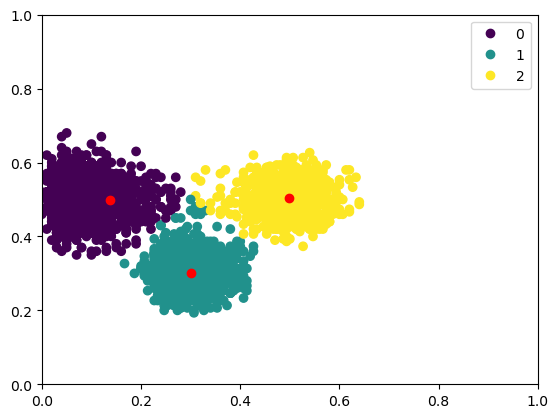

In [20]:
mb.fit(num_iter = 5000, lr = 0.001)

In [23]:
nmi = normalized_mutual_info_score(labels, mb.params['cluster_assignments']) # normalized_mutual_info_score(labels_true, labels_pred)
print(nmi) # 0 (no mutual information) and 1 (perfect correlation)

0.9135293836801217


In [ ]:
mb.params

### Using 4 components (1 beta private)

In [68]:
N1 = 2000
N2 = 1000
N3 = 2000
N4 = 1000
NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.5, n=100, N=N1, seed = 123)
NV2, DP2 = beta_binomial_component(p_x=0.5, p_y=0.5, n=150, N=N2, seed=123)
NV3, DP3 = beta_binomial_component(p_x=0.3, p_y=0.3, n=150, N=N3, seed=123)
NV4, DP4 = beta_binomial_component(p_x=0.3, p_y=0.0, n=150, N=N4, seed=123)
NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
NV = torch.concat((NV,NV4))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
DP = torch.concat((DP,DP4))
print(DP.shape)
# print(DP) 

torch.Size([6000, 2])
torch.Size([6000, 2])


In [69]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3
labels_4 = np.ones(N4) * 4

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))
labels = np.concatenate((labels, labels_4))

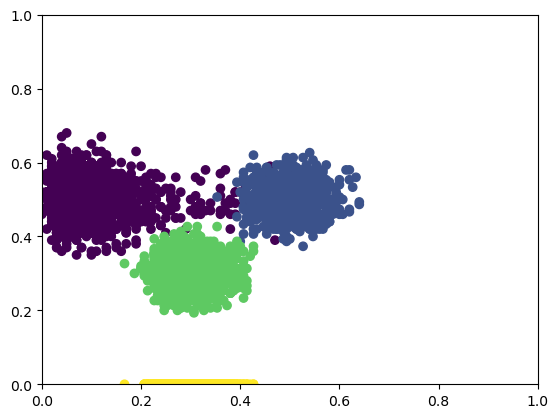

In [70]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [71]:
mb = mobster_MV(NV, DP, K = 4, seed = 12)

Beta:  tensor([[8.5637e-02, 4.9982e-01],
        [3.0139e-01, 3.0203e-01],
        [4.9654e-01, 5.0297e-01],
        [3.0095e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[8.5637e-02, 4.9982e-01],
        [3.0139e-01, 3.0203e-01],
        [4.9654e-01, 5.0297e-01],
        [3.0095e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = -727282560.0
Beta:  tensor([[8.5716e-02, 5.0007e-01],
        [3.0118e-01, 3.0182e-01],
        [4.9629e-01, 5.0272e-01],
        [3.0074e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[8.5559e-02, 4.9957e-01],
        [3.0118e-01, 3.0182e-01],
        [4.9629e-01, 5.0272e-01],
        [3.0074e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Beta:  tensor([[8.5794e-02, 5.0027e-01],
        [3.0097e-01, 3.0161e-01],
        [4.9605e-01, 5.0247e-01],
        [3.0053e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[8.5481e-02, 4.9932e-01],
        [3.0097e-01, 3.0161e-01],
        [4.9604e-01, 5.0247e-01],
  

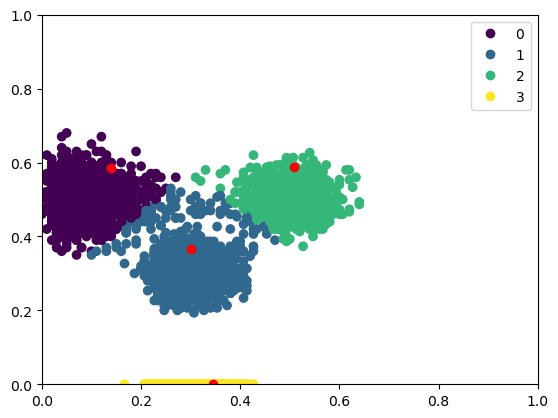

In [72]:
mb.fit(num_iter = 3000, lr = 0.001)

In [75]:
nmi = normalized_mutual_info_score(labels, mb.params['cluster_assignments']) # normalized_mutual_info_score(labels_true, labels_pred)
print(nmi) # 0 (no mutual information) and 1 (perfect correlation)

0.9306739334912011


In [77]:
mb.params

{'probs_beta': tensor([[1.3857e-01, 5.8612e-01],
         [3.0052e-01, 3.6703e-01],
         [5.0931e-01, 5.8892e-01],
         [3.4591e-01, 1.1755e-38]]),
 'probs_pareto': tensor([[4.0371e-02, 4.9703e-01],
         [1.9676e-01, 3.1536e-01],
         [2.5393e-01, 3.1508e-01],
         [6.4267e-02, 1.1755e-38]]),
 'weights': tensor([0.0318, 0.0380, 0.0735, 0.8567]),
 'delta': tensor([[[0.4741, 0.5259],
          [0.3568, 0.6432]],
 
         [[0.1086, 0.8914],
          [0.5866, 0.4134]],
 
         [[0.1406, 0.8594],
          [0.1481, 0.8519]],
 
         [[0.2959, 0.7041],
          [0.9990, 0.0010]]]),
 'alpha_pareto': tensor([[4.4480e-01, 3.5456e-01],
         [3.5962e-01, 4.0511e-01],
         [2.7687e-01, 3.3796e-01],
         [2.4021e-01, 3.6040e+02]]),
 'phi_beta': tensor([[0.2000, 0.5777],
         [0.2993, 0.3567],
         [0.5095, 0.5829],
         [0.3460, 0.2000]]),
 'k_beta': tensor([[  52.3209,  333.2738],
         [ 318.9074,  318.5145],
         [ 319.7621,  322.5824]

### rRACES data

In [78]:
NV_r = pd.read_csv("NV2.csv")
DP_r = pd.read_csv("DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)


torch.Size([593, 2])
torch.Size([593, 2])


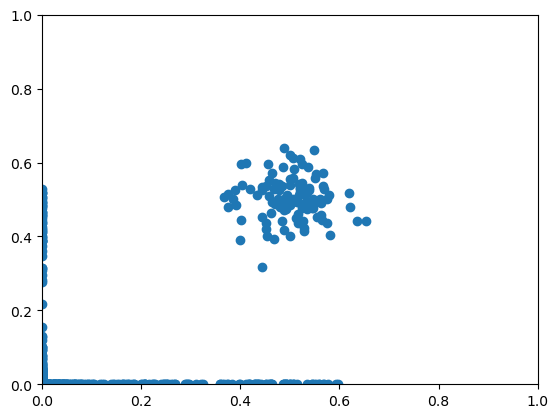

In [79]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

(array([329.,  31.,  17.,   6.,   7.,   8.,  12.,   9.,   6.,   5.,   1.,
         12.,  13.,  21.,  32.,  35.,  27.,  16.,   3.,   3.]),
 array([0.        , 0.03266667, 0.06533333, 0.098     , 0.13066667,
        0.16333333, 0.196     , 0.22866667, 0.26133333, 0.294     ,
        0.32666667, 0.35933333, 0.392     , 0.42466667, 0.45733333,
        0.49      , 0.52266667, 0.55533333, 0.588     , 0.62066667,
        0.65333333]),
 <BarContainer object of 20 artists>)

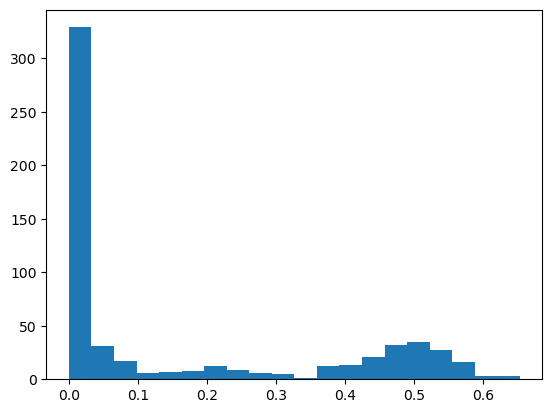

In [80]:
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)

In [81]:
mb = mobster_MV(NV, DP, K = 5, seed = 13)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Beta:  tensor([[2.1703e-01, 1.1755e-38],
        [4.9993e-01, 5.0346e-01],
        [1.4685e-02, 1.4474e-02],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[2.1703e-01, 1.1755e-38],
        [4.9993e-01, 5.0346e-01],
        [1.4685e-02, 1.4474e-02],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = -37138332.0
Beta:  tensor([[2.1686e-01, 1.1755e-38],
        [4.9968e-01, 5.0321e-01],
        [1.4700e-02, 1.4488e-02],
        [2.9832e-08, 4.2646e-01],
        [4.6932e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Pareto:  tensor([[2.1686e-01, 1.1755e-38],
        [4.9968e-01, 5.0321e-01],
        [1.4671e-02, 1.4459e-02],
        [2.9773e-08, 4.2646e-01],
        [4.6932e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Beta:  tensor([[2.1669e-01, 1.1755e-38],
        [4.9949e-01, 5.0296e-01],
        [1.4714e-02, 1.4502e-02],
        [2.9862e-08, 4.2622e-01],
     

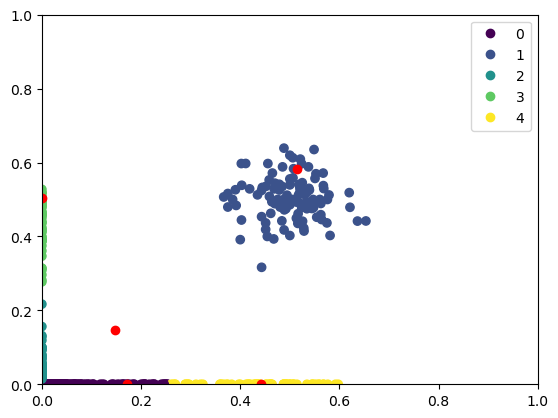

In [82]:
mb.fit(num_iter = 3000, lr = 0.001)

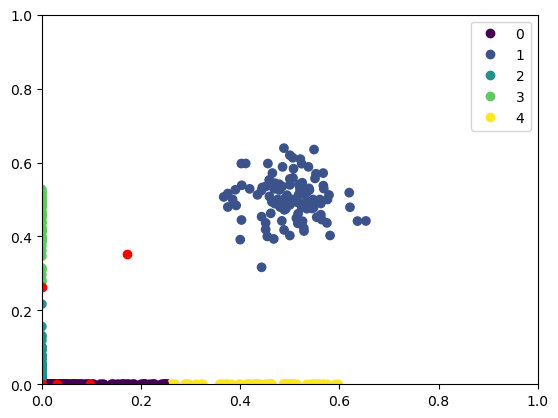

In [85]:
plt.xlim([0,1])
plt.ylim([0,1])
sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = mb.params["cluster_assignments"]) 
plt.scatter(mb.params['probs_pareto'][:, 0], mb.params['probs_pareto'][:, 1], c = 'r')
plt.legend(*sc.legend_elements())
# ["0","1","2","3","4"]
# plt.add_artist(a)
plt.show()

In [86]:
# Without small gaussian noise
mb.params

{'probs_beta': tensor([[1.7211e-01, 1.1755e-38],
         [5.1389e-01, 5.8258e-01],
         [1.4828e-01, 1.4733e-01],
         [5.9856e-07, 5.0475e-01],
         [4.4110e-01, 1.1755e-38]]),
 'probs_pareto': tensor([[9.6386e-02, 1.1755e-38],
         [1.7201e-01, 3.5162e-01],
         [9.4183e-04, 9.2768e-04],
         [8.7820e-09, 2.6241e-01],
         [3.1121e-02, 1.1755e-38]]),
 'weights': tensor([0.0283, 0.0118, 0.0298, 0.0061, 0.9240]),
 'delta': tensor([[[0.4060, 0.5940],
          [0.2183, 0.7817]],
 
         [[0.0141, 0.9859],
          [0.1067, 0.8933]],
 
         [[0.2931, 0.7069],
          [0.6189, 0.3811]],
 
         [[0.8579, 0.1421],
          [0.3682, 0.6318]],
 
         [[0.6627, 0.3373],
          [0.9900, 0.0100]]]),
 'alpha_pareto': tensor([[4.0553e-01, 1.6982e+00],
         [2.5737e-01, 3.6605e-01],
         [2.5989e-01, 2.6160e-01],
         [3.8108e+00, 4.1110e-01],
         [2.8706e-01, 3.4539e+02]]),
 'phi_beta': tensor([[0.2105, 0.2000],
         [0.5064, 

In [67]:
# With small gaussian noise
mb.params

{'probs_beta': tensor([[0.3478, 0.1221],
         [0.4972, 0.5283],
         [0.1052, 0.1219],
         [0.1219, 0.4706],
         [0.5287, 0.1324]]),
 'probs_pareto': tensor([[7.1939e-03, 4.8055e-05],
         [3.9062e-01, 3.1993e-01],
         [3.9483e-02, 5.3575e-03],
         [2.3809e-04, 6.2833e-02],
         [4.4779e-01, 1.6754e-03]]),
 'weights': tensor([0.7722, 0.1146, 0.0330, 0.0584, 0.0218]),
 'delta': tensor([[[0.7069, 0.2931],
          [0.9848, 0.0152]],
 
         [[0.0158, 0.9842],
          [0.0253, 0.9747]],
 
         [[0.9138, 0.0862],
          [0.1634, 0.8366]],
 
         [[0.9854, 0.0146],
          [0.1117, 0.8883]],
 
         [[0.0511, 0.9489],
          [0.7941, 0.2059]]]),
 'alpha_pareto': tensor([[  0.5007, 126.0728],
         [  0.1935,   0.1835],
         [  0.5830,   0.6626],
         [ 21.6223,   0.2435],
         [  0.2280,   1.1700]]),
 'phi_beta': tensor([[0.3093, 0.2000],
         [0.4975, 0.5273],
         [0.2000, 0.2000],
         [0.2000, 0.4677